In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [28]:
# Load your pickle data
subdirectory = "/Users/edilbekabdyrakhmanov/Documents/GitHub/bakeryy/3_Model/Neural_Net_Edilbek/final_data"
validation_features = pd.read_pickle(f"{subdirectory}/validation_features.pkl")
test_features = pd.read_pickle(f"{subdirectory}/test_features.pkl")
training_labels = pd.read_pickle(f"{subdirectory}/training_labels.pkl")
validation_labels = pd.read_pickle(f"{subdirectory}/validation_labels.pkl")
test_labels = pd.read_pickle(f"{subdirectory}/test_labels.pkl")

# load csv not from subdirectory!
training_features = pd.read_csv("/Users/edilbekabdyrakhmanov/Documents/GitHub/bakeryy/training_with_lags.csv")

# Drop 'Datum' column if present
for feature_set in [training_features, validation_features, test_features]:
    if 'Datum' in feature_set.columns:
        feature_set.drop('Datum', axis=1, inplace=True)

In [29]:

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Store results
histories = []
mapes = []
# Your robust MAPE function
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = (y_true != 0) & (~np.isnan(y_true)) & (~np.isnan(y_pred))
    if np.sum(non_zero_mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100


In [31]:
# Split features and labels
X = training_features.drop(columns=['Umsatz'])
y = training_features['Umsatz']

# Train-validation split (if you don't already have one)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Build Model 1
inputs = Input(shape=(X_train.shape[1],))
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1)(x)
model = Model(inputs, output)

# Compile
model.compile(optimizer=Adam(1e-4), loss='mse')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/300
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55540.8359 - val_loss: 56532.5547 - learning_rate: 1.0000e-04
Epoch 2/300
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54777.6172 - val_loss: 56056.8711 - learning_rate: 1.0000e-04
Epoch 3/300
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54472.8398 - val_loss: 55603.6680 - learning_rate: 1.0000e-04
Epoch 4/300
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54336.9805 - val_loss: 54991.9766 - learning_rate: 1.0000e-04
Epoch 5/300
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53307.2109 - val_loss: 54635.1250 - learning_rate: 1.0000e-04
Epoch 6/300
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53482.3984 - val_loss: 54138.3125 - learning_rate: 1.0000e-04
Epoch 7/300
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53416.5586 - val_loss: 53961.5156 - learning_rate: 1.0000e-04
Epoch 8/300
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54692.4180 - val_loss: 53298.4805 - learning_rate: 1.0000e-04
Epoch 9/300
221/

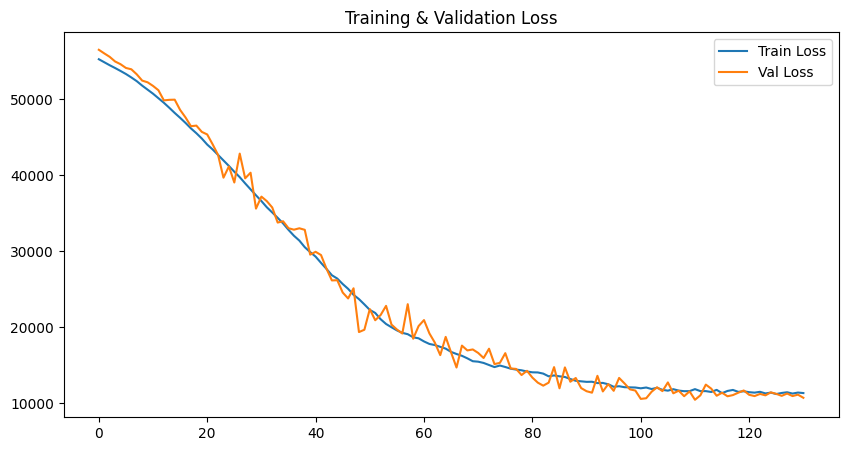

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
Train MAPE: 55.07% | Val MAPE: 53.29%
Train R²: 0.6280 | Val R²: 0.5775


In [32]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

# Evaluation metrics
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = (y_true != 0) & (~np.isnan(y_true)) & (~np.isnan(y_pred))
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Predictions
train_preds = model.predict(X_train).flatten()
val_preds = model.predict(X_val).flatten()

train_mape = mape(y_train, train_preds)
val_mape = mape(y_val, val_preds)
train_r2 = r2_score(y_train, train_preds)
val_r2 = r2_score(y_val, val_preds)

print(f"Train MAPE: {train_mape:.2f}% | Val MAPE: {val_mape:.2f}%")
print(f"Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")


In [27]:
training_features.to_csv('training_features.csv', index=False)
training_labels.to_csv('training_labels.csv', index=False)

In [25]:
# Plot the loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

AttributeError: 'dict' object has no attribute 'history'

<Figure size 1200x600 with 0 Axes>

In [26]:
# Robust MAPE function
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = (y_true != 0) & (~np.isnan(y_true)) & (~np.isnan(y_pred))
    if np.sum(non_zero_mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Predictions
train_preds = model.predict(training_features).flatten()
val_preds = model.predict(validation_features).flatten()

# Compute MAPE
train_mape = mape(training_labels.values.flatten(), train_preds)
val_mape = mape(validation_labels.values.flatten(), val_preds)

print(f"Training MAPE: {train_mape:.2f}%")
print(f"Validation MAPE: {val_mape:.2f}%")


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
Training MAPE: 17.81%
Validation MAPE: 19.31%


In [18]:
from sklearn.metrics import r2_score

# Compute R^2
train_r2 = r2_score(training_labels.values.flatten(), train_preds)
val_r2 = r2_score(validation_labels.values.flatten(), val_preds)

print(f"Training R^2: {train_r2:.4f}")
print(f"Validation R^2: {val_r2:.4f}")


Training R^2: 0.9208
Validation R^2: 0.8989
